# Flax-pilot Trainer with pre-trained models


**Use TensorFlow-cpu instead of TensorFlow to avoid any issues between TensorFlow & Jax.**

In [1]:
!pip install -q tensorflow-cpu

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.4.1 which is incompatible.
tensorflow 2.15.0 requires ml-dtypes~=0.2.0, but you have ml-dtypes 0.4.0 which is incompatible.
tensorflow 2.15.0 requires tensorboard<2.16,>=2.15, but you have tensorboard 2.17.0 which is incompatible.


In [3]:
import jax
import optax
import functools
import tensorflow as tf
import flax.linen as nn
import jax.numpy as jnp
import jax.random as jr


In [4]:
!pip install flax-pilot

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 1.3 MB/s eta 0:00:00ta 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for typing: filename=typing-3.7.4.3-py3-none-any.whl size=26304 sha256=1b79a7764f78a49f81d60f2b172dccaecd00395965ce3f772e7e372b4e25b013
  Stored in directory: /root/.cache/pip/wheels/7c/d0/9e/1f26ebb66d9e1732e4098bc5a6c2d91f6c9a529838f0284890
Successfully built typing


**Refer to `vae-using-pre-trained` b4 using this notebook for better clarity**

In [5]:
class BackBone(nn.Module):
    @nn.compact
    def __call__(self, x, deterministic):
        x = nn.Conv(features=32, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = nn.Conv(features=64, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        return x

### Fine-tuning

**Lets use the backbone params for other tasks. In this example lets use the trained backbone for Encoder part of VAE-GAN-CFG**


**Extract the params of backbone**

In [15]:
import orbax

In [16]:
temp_ckpt = orbax.checkpoint.PyTreeCheckpointer()
classifier_state = temp_ckpt.restore("/kaggle/working/pre-trained-models/manual_mnist_save2/2340/default")
base_params = classifier_state['params']['params']['base']

/opt/conda/lib/python3.10/site-packages/orbax/checkpoint/type_handlers.py:1407: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


**VAE-GAN-CFG Model**

**Lets use the backbone in the encoder.**

In [7]:
class Encoder(nn.Module):
    base: nn.Module = BackBone()
    
    def setup(self,):
        self.ff = nn.Sequential([
            nn.Dense(16),
            nn.relu,
            nn.Dense(4)
        ])
    
        
    def __call__(self, x, deterministic):
        x = self.base(x, deterministic)
        x = x.reshape(x.shape[0], -1)
        x = self.ff(x)
        mean, logvar = jnp.split(x, 2, -1)
        return mean, logvar
    
    
class Decoder(nn.Module):
    def setup(self,):
        self.cls_embedding = nn.Embed(10, 128)
    
    @nn.compact
    def __call__(self, z, c, deterministic):
        y = nn.relu(nn.Dense(49*128)(z))
        c = self.cls_embedding(c.astype(jnp.int32))
        
        y = y.reshape(y.shape[0], 7, 7, 128)
        y += c[:, None, None, :]
        y = nn.GroupNorm()(y)
        
        y = nn.gelu(nn.ConvTranspose(features=128, kernel_size=(3, 3), strides=2, padding='SAME')(y))
        y += c[: ,None, None, :]
        y = nn.GroupNorm()(y)
        
        y = nn.gelu(nn.ConvTranspose(features=64, kernel_size=(3, 3), strides=2, padding='SAME')(y))
        y += (nn.Dropout(0.3, deterministic=deterministic)(nn.Dense(64)(c))[:, None, None, :])
        y = nn.GroupNorm()(y)
        
        y = nn.ConvTranspose(features=1, kernel_size=(3, 3), padding='SAME')(y)
        y = nn.sigmoid(y)
        return y
    
        
class VAE(nn.Module):
    encoder: nn.Module = Encoder()
    decoder: nn.Module = Decoder()
    
    # Must have 'deterministic param'.
    @nn.compact
    def __call__(self, x, c, deterministic):
        mean, logvar = self.encode(x, deterministic)
        z = self.reparam_trick(mean, logvar)
        y = self.decode(z, c, deterministic)
        return (mean, logvar), y
        
    def encode(self, x, deterministic):
        return self.encoder(x, deterministic)
    
    def decode(self, x, c, deterministic):
        return self.decoder(x, c, deterministic)
    
    def reparam_trick(self, mean, logvar):
        e = jr.normal(self.make_rng('normal'), mean.shape)
        return mean + jnp.exp(0.5*logvar)*e
    

class Discriminator(nn.Module):
    @nn.compact
    def __call__(self, x, deterministic):
        x = nn.Conv(features=64, kernel_size=(5, 5), strides=(2, 2), padding='SAME')(x)
        x = nn.leaky_relu(x)
        x = nn.Dropout(0.3, deterministic=deterministic)(x)
        
        x = nn.Conv(features=128, kernel_size=(5, 5), strides=(2, 2), padding='SAME')(x)
        x = nn.leaky_relu(x)
        x = nn.Dropout(0.3, deterministic=deterministic)(x)
        
        x = x.reshape((x.shape[0], -1)) 
        x = nn.Dense(features=16)(x)
        return x

**Encapsulated Model**

In [8]:
class GAN(nn.Module):
    def setup(self,):
        self.discriminator = Discriminator()
        self.generator = VAE()
    
    @nn.compact
    def __call__(self, x, c, deterministic):
        (mean, logvar), y = self.generator_call(x, c, deterministic)
        dtrue = self.disc(x, deterministic)
        dfake = self.disc(y, deterministic)
        return y, mean, logvar, dtrue, dfake
    
    def generator_call(self, x, c, deterministic):
        return self.generator(x, c, deterministic)
    
    def decode(self, x, c, deterministic):
        return self.generator.decode(x, c, deterministic)
    
    def disc(self, x, deterministic):
        return self.discriminator(x, deterministic)

**Data loading**

In [9]:
(x_train, y_train), (x_val, y_val) = tf.keras.datasets.mnist.load_data()

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.shuffle(256).batch(128, True)

def func(x, c):
    return x[:, :, :, None]/255, c
    
train_ds = train_ds.map(func, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.batch(2, True)
train_ds = train_ds.repeat().as_numpy_iterator()

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_ds = val_ds.shuffle(256).batch(128, True)
val_ds = val_ds.map(func, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(2, True)
val_ds = val_ds.repeat().as_numpy_iterator()

train_ds, val_ds

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


(NumpyIterator(iterator=<tensorflow.python.data.ops.iterator_ops.OwnedIterator object at 0x79c2b3a318a0>),
 NumpyIterator(iterator=<tensorflow.python.data.ops.iterator_ops.OwnedIterator object at 0x79c2b382b880>))

**Loss function**

In [10]:
disc_start = 2000
disc_weight = 0.7
disc_factor_4_gen=0.3


def loss_fn(params, apply, sample, deterministic, global_key, step, obj):
    x, c = sample
    y, mean, logvar, dt, df = apply(params, x, c, deterministic=deterministic, rngs={'dropout': global_key, 'normal': global_key})

    if obj=='generator':
        recons_loss = -(x*jnp.log(y+0.00001) + (1-x)*jnp.log((1-y)+0.00001)).sum(axis=(1, 2)).mean()
        kl_loss = (-0.5 * (1 + logvar - jnp.square(mean) - jnp.exp(logvar))).sum(axis=(1, )).mean()
        gen_df_loss = -df.mean()
        loss = recons_loss + (kl_loss) + (gen_df_loss*disc_factor_4_gen)
        gen_loss = loss  
        
        return gen_loss, {
            'lt': {'recons_loss': recons_loss, 'kl_loss': kl_loss, 'gen_loss': gen_df_loss}, 
            'mt': dict()
        }

    if obj=='discriminator':
        disc_dt_loss = nn.relu(1.0 - dt).mean()
        disc_df_loss = nn.relu(1.0 + df).mean()
        disc_loss = 0.5* (disc_dt_loss + disc_df_loss)
        
        # Dynamic weighing
        weight = (step >= disc_start)*disc_weight
        disc_loss = disc_loss*weight
        
        return  disc_loss, {
            'lt': {'dict_true_op': dt.mean(), 'dict_fake_op': df.mean()}, 
            'mt': dict()
        }

**Trackers**

In [11]:
from fpilot import BasicTrackers as tr

trackers = {
        'lt': {'recons_loss': tr.Mean(), 'kl_loss': tr.Mean(), 'gen_loss': tr.Mean(), 'dict_true_op': tr.Mean(), 'dict_fake_op': tr.Mean()},
        'mt':{}
}

**Create optimizer mask**

 - True: Apply Gradients
 - False: Dont Apply Gradients

In [17]:
mask = {
    'params': # first key `params` is default for any mask. 
        {'generator':
            {
                'encoder': {
                    'base': False,
                    'ff': True
                },
                'decoder': True
            },
         'discriminator': True
        }
}

**Initiate trainer**

In [18]:
from fpilot import Trainer

trainer = Trainer(GAN(), {'x': (1, 28, 28, 1), 'c': (1, )}, {'discriminator': optax.adam(4e-5), 'generator': optax.adam(4e-5)}, loss_fn, trackers, mask)

**Set the params of Backbone to its pre-trained weights**<br>
Check the docstring of the function for explaination

In [19]:
replacement_path = [
    ['params', 'generator', 'encoder', 'base']
]
replacement_params = [
    base_params
]
trainer.transfer_params(replacement_path, replacement_params)

**Train the VAE**

In [20]:
trainer.train(10, train_ds, val_ds, 60000//256, 10000//256, '/kaggle/working/gans-pretrained/newgan', 3)

Epoch 1: 100%|██████████| 234/234 [00:20<00:00, 11.62it/s]


Train:  dict_fake_op: 0.0058324765, dict_true_op: 0.018779604, gen_loss: -0.0058324765, kl_loss: 2.2683325, recons_loss: 286.26117, time: 20.14922022819519
Val:  dict_fake_op: 0.01654509, dict_true_op: 0.017495245, gen_loss: -0.01654509, kl_loss: 3.598163, recons_loss: 197.01778, time: 3.7354047298431396
State saved..


Epoch 2: 100%|██████████| 234/234 [00:07<00:00, 32.28it/s]


Train:  dict_fake_op: 0.01603167, dict_true_op: 0.018709019, gen_loss: -0.01603167, kl_loss: 3.7454753, recons_loss: 190.46875, time: 7.252300500869751
Val:  dict_fake_op: 0.016676236, dict_true_op: 0.017501153, gen_loss: -0.016676236, kl_loss: 3.7691011, recons_loss: 183.2698, time: 0.41295957565307617
State saved..


Epoch 3: 100%|██████████| 234/234 [00:07<00:00, 31.92it/s]


Train:  dict_fake_op: 0.016597308, dict_true_op: 0.01869595, gen_loss: -0.016597308, kl_loss: 3.687712, recons_loss: 178.99327, time: 7.334670782089233
Val:  dict_fake_op: 0.015798088, dict_true_op: 0.017493045, gen_loss: -0.015798088, kl_loss: 3.7544365, recons_loss: 172.68332, time: 0.420945405960083
State saved..


Epoch 4: 100%|██████████| 234/234 [00:07<00:00, 31.53it/s]


Train:  dict_fake_op: 0.016485568, dict_true_op: 0.018782951, gen_loss: -0.016485568, kl_loss: 3.9823704, recons_loss: 168.79095, time: 7.425416707992554
Val:  dict_fake_op: 0.015970465, dict_true_op: 0.017488781, gen_loss: -0.015970465, kl_loss: 4.3666153, recons_loss: 162.72714, time: 0.4250781536102295
State saved..


Epoch 5: 100%|██████████| 234/234 [00:07<00:00, 31.17it/s]


Train:  dict_fake_op: 0.016561653, dict_true_op: 0.018563595, gen_loss: -0.016561653, kl_loss: 4.6278157, recons_loss: 160.05447, time: 7.510968208312988
Val:  dict_fake_op: 0.015652701, dict_true_op: 0.017495705, gen_loss: -0.015652701, kl_loss: 4.960394, recons_loss: 155.84193, time: 0.43460655212402344
State saved..


Epoch 6: 100%|██████████| 234/234 [00:07<00:00, 30.73it/s]


Train:  dict_fake_op: 0.01698362, dict_true_op: 0.018709503, gen_loss: -0.01698362, kl_loss: 5.1080103, recons_loss: 153.85709, time: 7.618940353393555
Val:  dict_fake_op: 0.015366433, dict_true_op: 0.017483745, gen_loss: -0.015366433, kl_loss: 5.339736, recons_loss: 151.12161, time: 0.43846964836120605
State saved..


Epoch 7: 100%|██████████| 234/234 [00:07<00:00, 30.35it/s]


Train:  dict_fake_op: 0.017033046, dict_true_op: 0.018830508, gen_loss: -0.017033046, kl_loss: 5.384862, recons_loss: 149.61096, time: 7.714384078979492
Val:  dict_fake_op: 0.0154061, dict_true_op: 0.017498601, gen_loss: -0.0154061, kl_loss: 5.528931, recons_loss: 147.62442, time: 0.4526188373565674
State saved..


Epoch 8: 100%|██████████| 234/234 [00:07<00:00, 29.85it/s]


Train:  dict_fake_op: 0.017093645, dict_true_op: 0.018774653, gen_loss: -0.017093645, kl_loss: 5.545311, recons_loss: 146.72256, time: 7.841840982437134
Val:  dict_fake_op: 0.015111924, dict_true_op: 0.01748756, gen_loss: -0.015111924, kl_loss: 5.661468, recons_loss: 145.2546, time: 0.4625566005706787
State saved..


Epoch 9: 100%|██████████| 234/234 [00:07<00:00, 29.32it/s]


Train:  dict_fake_op: -0.49922004, dict_true_op: 0.911755, gen_loss: 0.49922004, kl_loss: 5.640579, recons_loss: 144.54224, time: 7.983372449874878
Val:  dict_fake_op: -2.2049947, dict_true_op: 3.2098985, gen_loss: 2.2049947, kl_loss: 5.714872, recons_loss: 143.61407, time: 0.46388936042785645
State saved..


Epoch 10: 100%|██████████| 234/234 [00:07<00:00, 29.85it/s]


Train:  dict_fake_op: -2.222529, dict_true_op: 4.5563517, gen_loss: 2.222529, kl_loss: 5.6890526, recons_loss: 142.94, time: 7.841549634933472
Val:  dict_fake_op: -3.085878, dict_true_op: 4.617658, gen_loss: 3.085878, kl_loss: 5.7452765, recons_loss: 142.1434, time: 0.4466125965118408
State saved..


**Lets check if weights have changed**

In [21]:
pre_base_params = base_params
gan_base_params = trainer.state.params['params']['generator']['encoder']['base']
results = jax.tree_util.tree_map(lambda x, y: jnp.all(x==y), pre_base_params, gan_base_params)
results

{'Conv_0': {'bias': Array(True, dtype=bool),
  'kernel': Array(True, dtype=bool)},
 'Conv_1': {'bias': Array(True, dtype=bool),
  'kernel': Array(True, dtype=bool)}}

The above output shows that the weights of the backbone haven't changed during VAE training ensuring frozen weights

In [22]:
rand = jr.normal(jr.PRNGKey(23), (2, 50, 2))

c = jnp.array([
    jnp.full((10, ), i) for i in range(10)
]).reshape(2, 50)

rngs = {'normal': jax.random.PRNGKey(18)}

tensor_inputs = {'x': rand, 'c': c}
output = trainer(rngs, tensor_inputs, method='decode', deterministic=True)

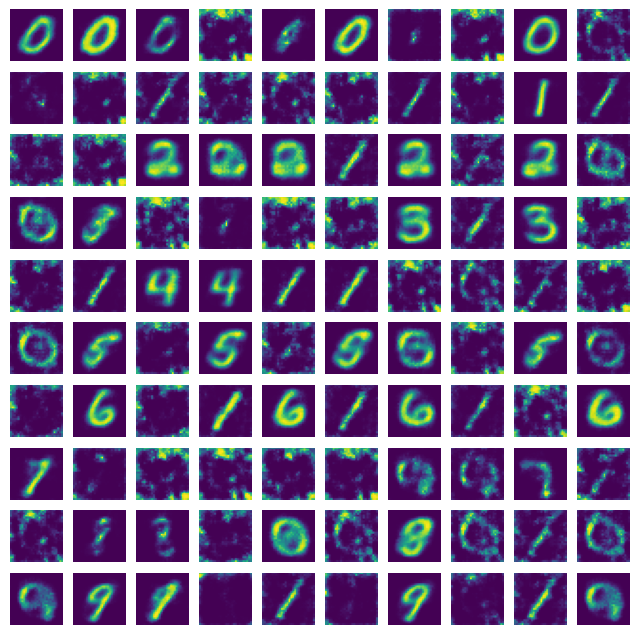

In [23]:
import matplotlib.pyplot as plt

x = output.reshape(100, 28, 28, 1)

plot_images = iter(x)
fig, ax = plt.subplots(10, 10, figsize=(8, 8))

for i in range(10):
    for j in range(10):
        ax[i][j].imshow(next(plot_images))
        ax[i][j].axis('off')

Further training will lead to better results.